In [1]:
!pip install apafib --upgrade  --quiet
!pip install pmlb --upgrade  --quiet
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Imports iniciales:

In [2]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

# Ejercicio 1: De vacaciones
Un problema frecuente en el análisis de las web de opiniones es el obtener perfiles de las personas para luego poder hacer predicciones y asociarlo con recomendaciones. El conjunto de datos Travel Reviews recolecta la media de las opiniones de un conjunto de usuarios sobre diferentes categorías de atracciones/lugares/locales turísticos. Todas las opiniones de cada usuario de una categoría se asociaron a un valor entre 0 y 4, y luego se hizo una media de las opiniones. El objetivo de este problema es experimentar con diferentes clasificadores lineales para evaluar la posibilidad de usarlos para hacer predicciones del perfil de los usuarios (atributo class).

In [4]:
from apafib import load_travel_review
travel_data = load_travel_review()

# La variable respuesta será la primera

cols = list(travel_data.columns)
cols.remove('class')
cols.insert(0, 'class')
travel_data = travel_data.reindex(columns=cols)

travel_data.head()

,class,art galleries,dance clubs,juice bars,restaurants,museums,resorts,parks/picnic spots,beaches,theaters,religious institutions
0,1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,2,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,2,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [5]:
travel_data.describe(include='all').T
travel_data.info()
y = travel_data['class']
y.value_counts()

,count,mean,std,min,25%,50%,75%,max
class,980.0,1.634,1.119,0.00,1.00,2.00,3.000,3.00
art galleries,980.0,0.893,0.327,0.34,0.67,0.83,1.020,3.22
dance clubs,980.0,1.353,0.478,0.00,1.08,1.28,1.560,3.64
juice bars,980.0,1.013,0.789,0.13,0.27,0.82,1.573,3.62
restaurants,980.0,0.532,0.280,0.15,0.41,0.50,0.580,3.44
museums,980.0,0.940,0.437,0.06,0.64,0.90,1.200,3.30
resorts,980.0,1.843,0.540,0.14,1.46,1.80,2.200,3.76
parks/picnic spots,980.0,3.181,0.008,3.16,3.18,3.18,3.180,3.21
beaches,980.0,2.835,0.138,2.42,2.74,2.82,2.910,3.39
theaters,980.0,1.569,0.365,0.74,1.31,1.54,1.760,3.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   class                   980 non-null    int64  
 1   art galleries           980 non-null    float64
 2   dance clubs             980 non-null    float64
 3   juice bars              980 non-null    float64
 4   restaurants             980 non-null    float64
 5   museums                 980 non-null    float64
 6   resorts                 980 non-null    float64
 7   parks/picnic spots      980 non-null    float64
 8   beaches                 980 non-null    float64
 9   theaters                980 non-null    float64
 10  religious institutions  980 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 84.3 KB


class
3    298
1    255
2    226
0    201
Name: count, dtype: int64

Observamos que no tenemos variables categóricas, no requieren transformaciones.

Veremos ahora si tenemos missing values:

In [6]:
X = travel_data.drop(columns=['class'])
X.isna().sum().sort_values(ascending=False)

art galleries             0
dance clubs               0
juice bars                0
restaurants               0
museums                   0
resorts                   0
parks/picnic spots        0
beaches                   0
theaters                  0
religious institutions    0
dtype: int64

Ya que no tenemos, nos ahorramos el tener que rellenarlos o borrar las filas que los contengan.

## Apartado A: 
Divide los datos en un conjunto de entrenamiento y otro de test (70 %/30 %), la partición debe estratificarse (fija también el estado del generador de números aleatorios para la reproducibilidad). Haz una visualización mínima de las variables para hacerte una idea de los datos y calcula sus correlaciones. Verás que las variables son todas continuas. Algunas variables no parecen muy gausianas. Haremos dos conjuntos de datos, uno que tenga las variables originales y otro en el que las variables que se desvíen bastante de la gausianidad las transformaremos a algo más cercano a una gausiana usando el método QuantileTransformer de scikit-learn. Este usa los cuantiles de los datos para que coincidan con los cuantiles de la gausiana, básicamente hace corresponder la CDF empírica de los datos y la CDF teórica de la gausiana. Normaliza adecuadamente los datos.

'train_test_split' nos permite estratificar (mantener la proporción de clases) los datos, realizaremos la partición:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

No está de más observar como se distribuyen las clases para saber si están desbalanceadas, lo cual puede causar tendencias incorrectas en la posterior clasificación de los datos.

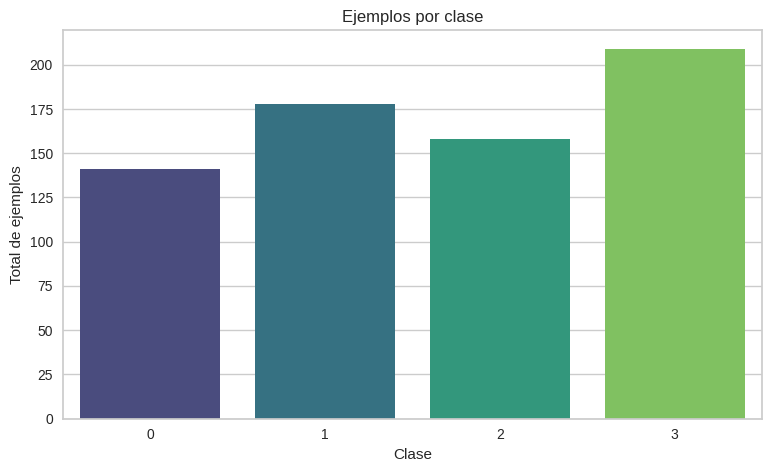

In [8]:
class_elems = y_train.value_counts().reset_index()
class_elems.columns = ['class', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(x='class', y='count', data=class_elems, palette='viridis')
plt.title('Ejemplos por clase')
plt.xlabel('Clase')
plt.ylabel('Total de ejemplos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show();

Vemos como, si bien las diferencias no son abismales, la clase 0 recibe un número bastante disminuido de datos, mientras que la 3 recibe el mayor. Debemos tener esto en cuenta para el estudio posterior.

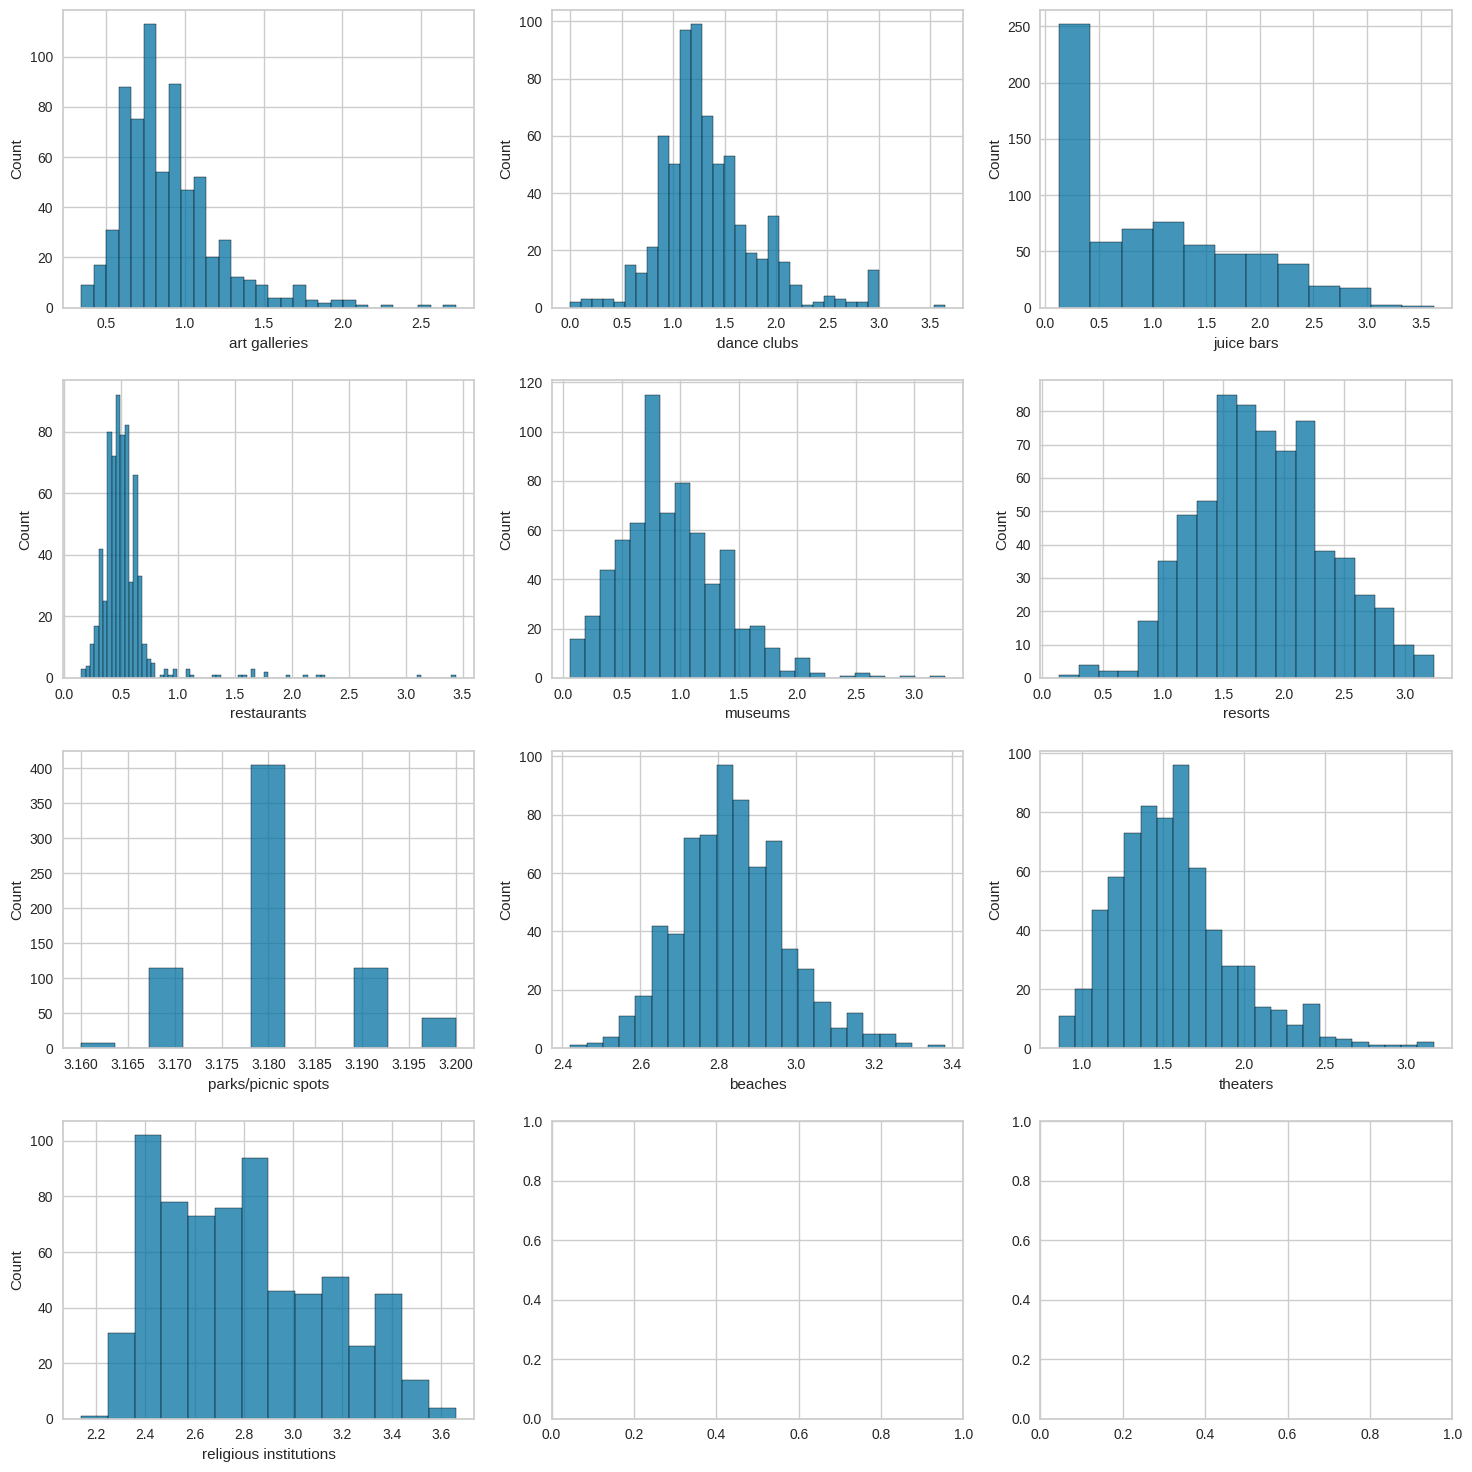

In [9]:
fig, axes = plt.subplots(4,3,figsize=(15,15))

X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns=X.columns
for i, c in enumerate(X.columns):
    ax = axes.reshape(-1)[i]
    if X_train_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_frame,ax=ax)
plt.tight_layout()

Tenemos 3 variables con distribución gaussiana: 'parks/picnic spots', 'beaches' y 'resorts' (debatible). El resto siguen una distribución sesgada hacia un lado, en general los valores más bajos.

Antes de dividir en dos el conjunto de datos, miraremos las correlaciones entre las variables:

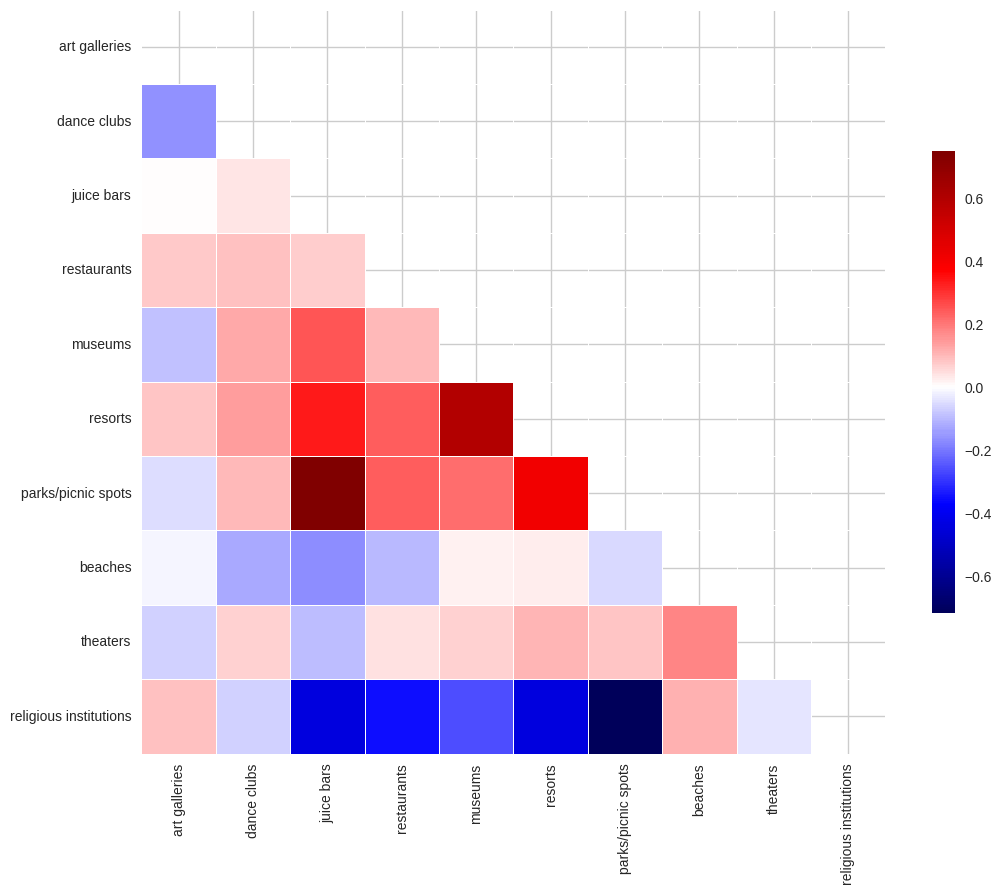

In [10]:
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Como datos destacables, observamos que las correlaciones más fuertes se encuentran en resorts y parks/picnic spots. Por el contrario, religious institutions parece tener el efecto contrario a estas dos últimas.

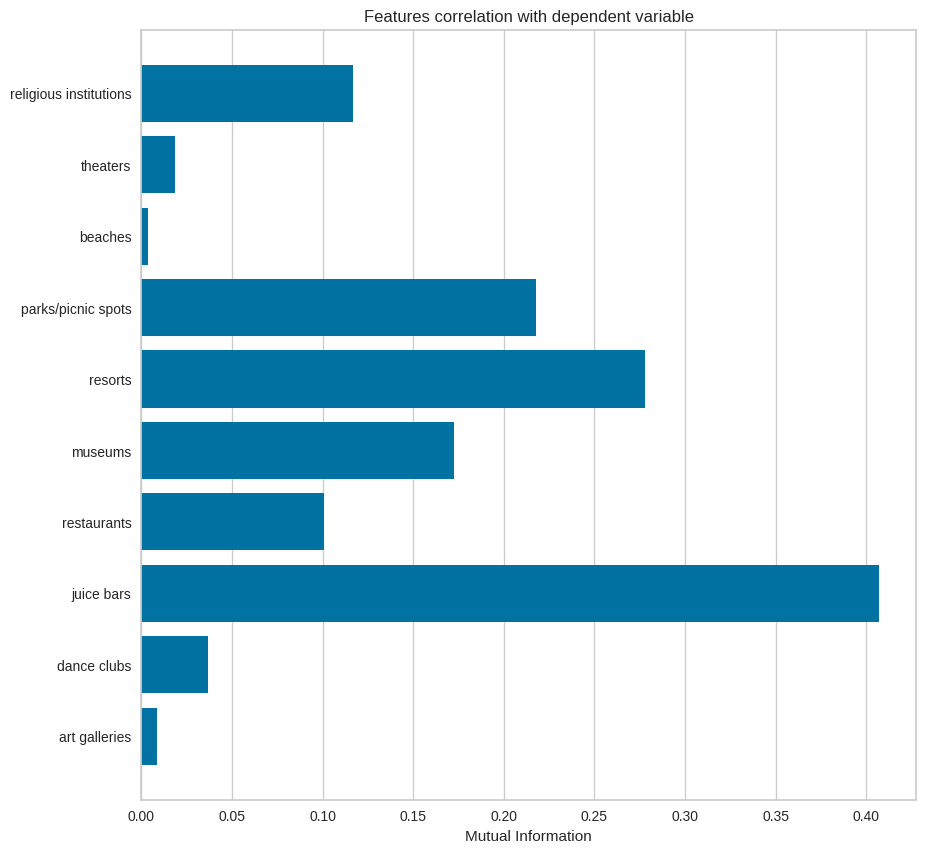

In [11]:
plt.figure(figsize=(10,10))
visualizer = feature_correlation(X_train_frame, y_train, labels=list(X_train_frame.columns),method='mutual_info-classification');

Se observa que la mayoría de variables tienen un grado de correlación con la variable objetivo ('class'), excepto 'theaters', 'beaches' y 'art galleries', donde es casi nulo. Otras variables con poco peso (pero más notable) serían 'dance clubs' y 'restaurants'.

Por conveniencia, a partir de ahora el primer grupo será referido como O (original) y G (gaussianas)

In [12]:
gaussian_columns = ['parks/picnic spots', 'beaches', 'resorts']

X_train_o = X_train
X_train_g = X_train.copy()

X_test_o = X_test
X_test_g = X_test.copy()

X_train_trans = X_train_g.drop(columns=gaussian_columns)
X2 = X_train_g.drop(columns=gaussian_columns)
X_test_trans = X_test_g.drop(columns=gaussian_columns)
X3 = X_test_g.drop(columns=gaussian_columns)

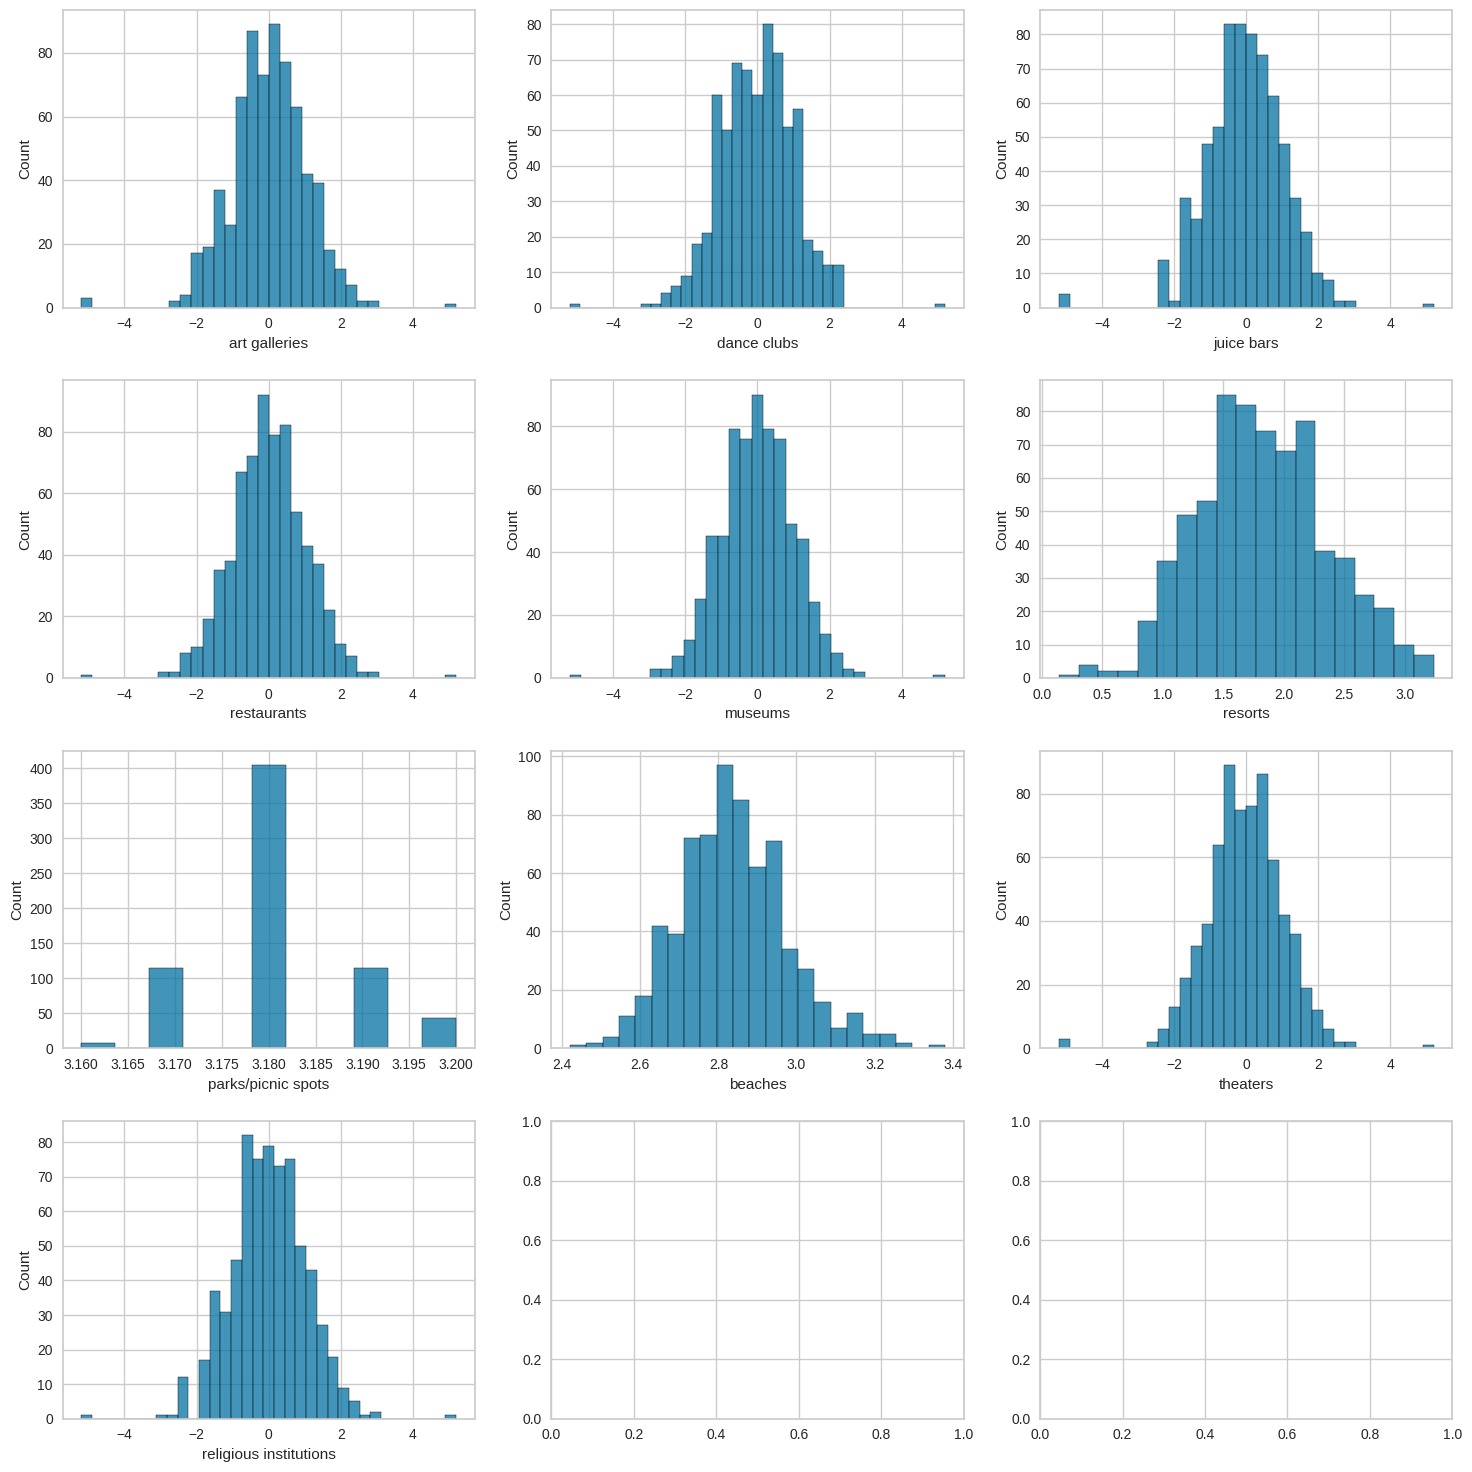

In [13]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal', random_state=42)

X_train_trans = pd.DataFrame(
    scaler.fit_transform(X_train_trans),
    columns=X2.columns, 
    index=X_train_trans.index       
)

for col in X_train_trans.columns:
    X_train_g[col] = X_train_trans[col]

X_test_trans = pd.DataFrame(
    scaler.fit_transform(X_test_trans),
    columns=X3.columns, 
    index=X_test_trans.index       
)

for col in X_test_trans.columns:
    X_test_g[col] = X_test_trans[col]

fig, axes = plt.subplots(4,3,figsize=(15,15))

X_train_frame = pd.DataFrame(X_train_g)

for i, c in enumerate(X_train_frame.columns):
    ax = axes.reshape(-1)[i]
    if X_train_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_frame,ax=ax)
plt.tight_layout()

Nuestro conjunto inicialmente no gaussiano en la mayoría de variables ha sido correctamente transformado a datos más cercanos a distribuciones gaussianas.

Por último, normalizaremos los datos de las variables. Usaremos StandardScaler para no distorsionar los datos pero estandarizarlos.

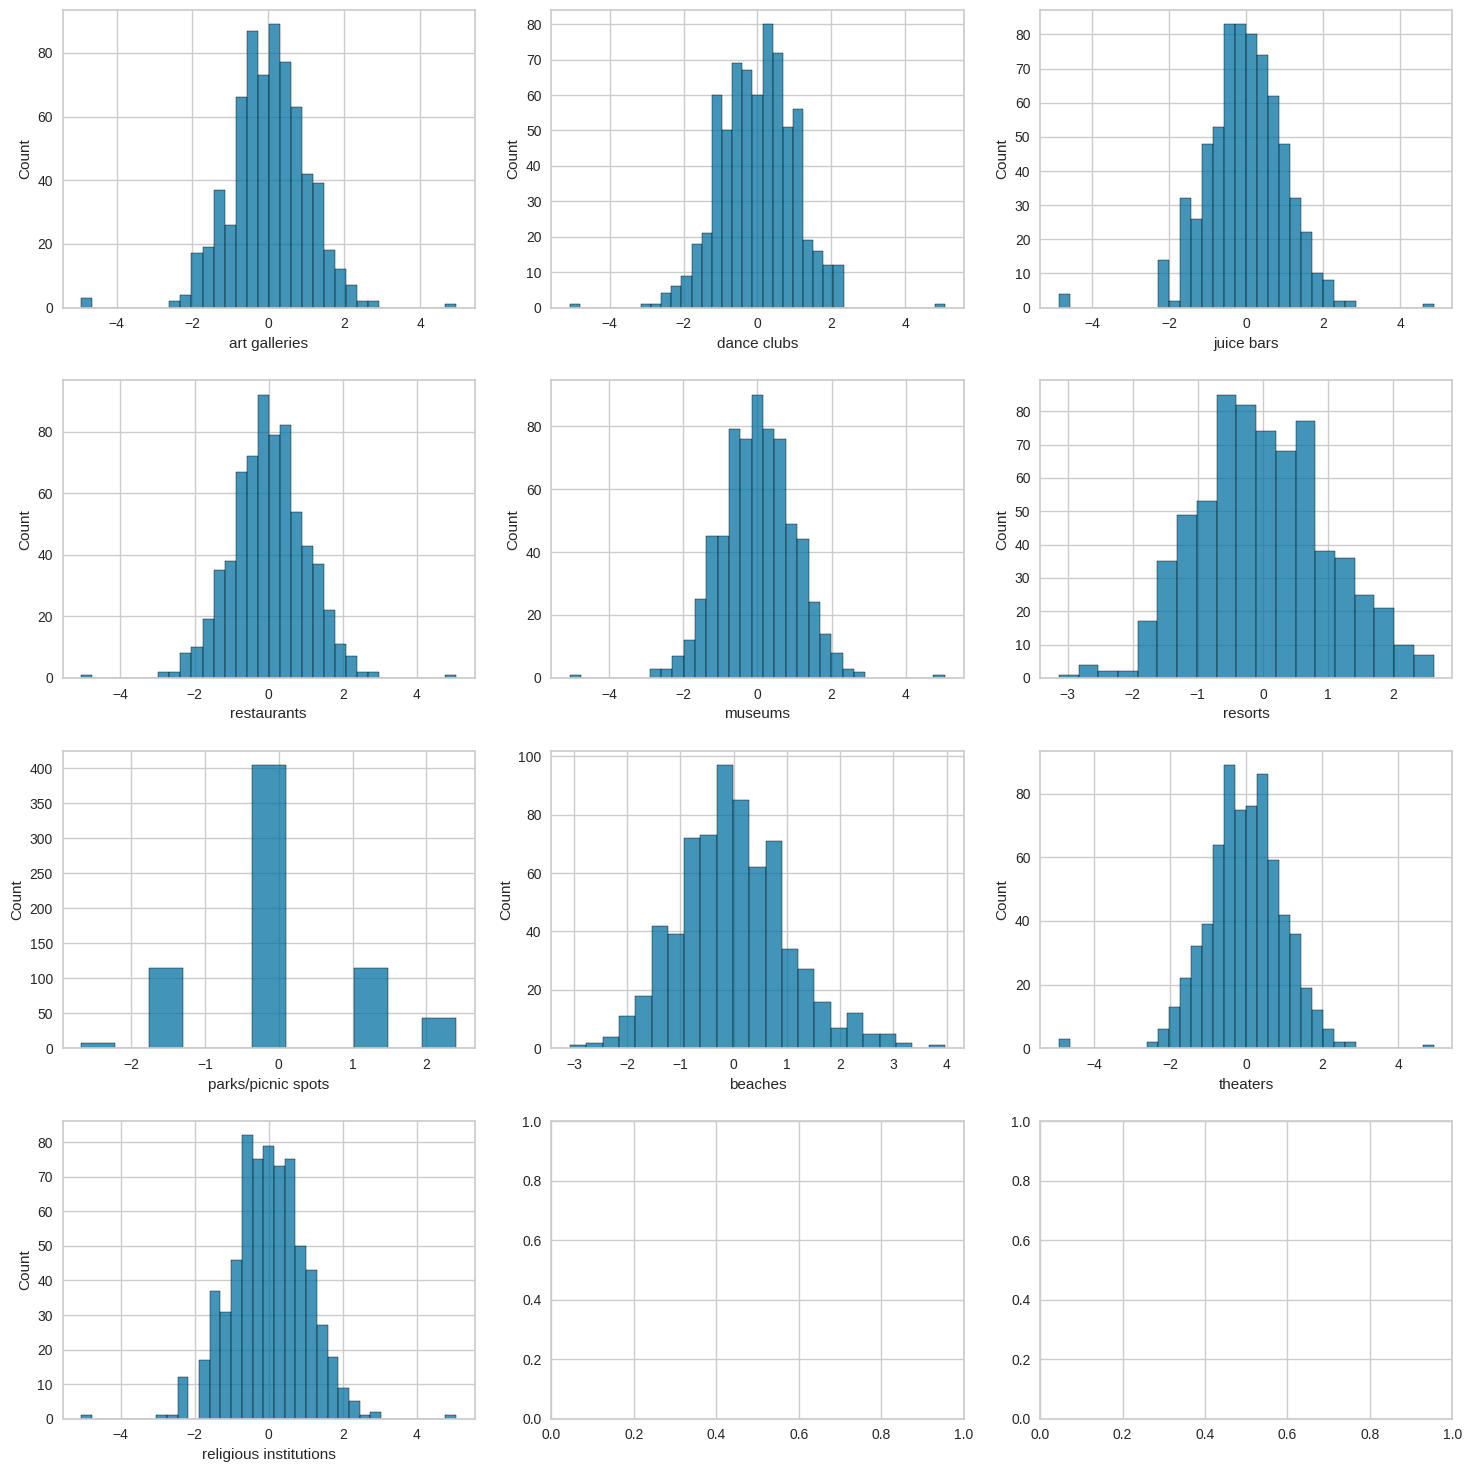

In [14]:
from sklearn.preprocessing import StandardScaler
stSc = StandardScaler()
X_train_g = stSc.fit_transform(X_train_g)
X_test_g = stSc.transform(X_test_g)

X_train_o = stSc.fit_transform(X_train_o)
X_test_o = stSc.transform(X_test_o)

fig, axes = plt.subplots(4,3,figsize=(15,15))
X_train_frame = pd.DataFrame(X_train_g)
X_train_frame.columns=X.columns
for i, c in enumerate(X.columns):
    ax = axes.reshape(-1)[i]
    if X_train_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_frame,ax=ax)
plt.tight_layout()

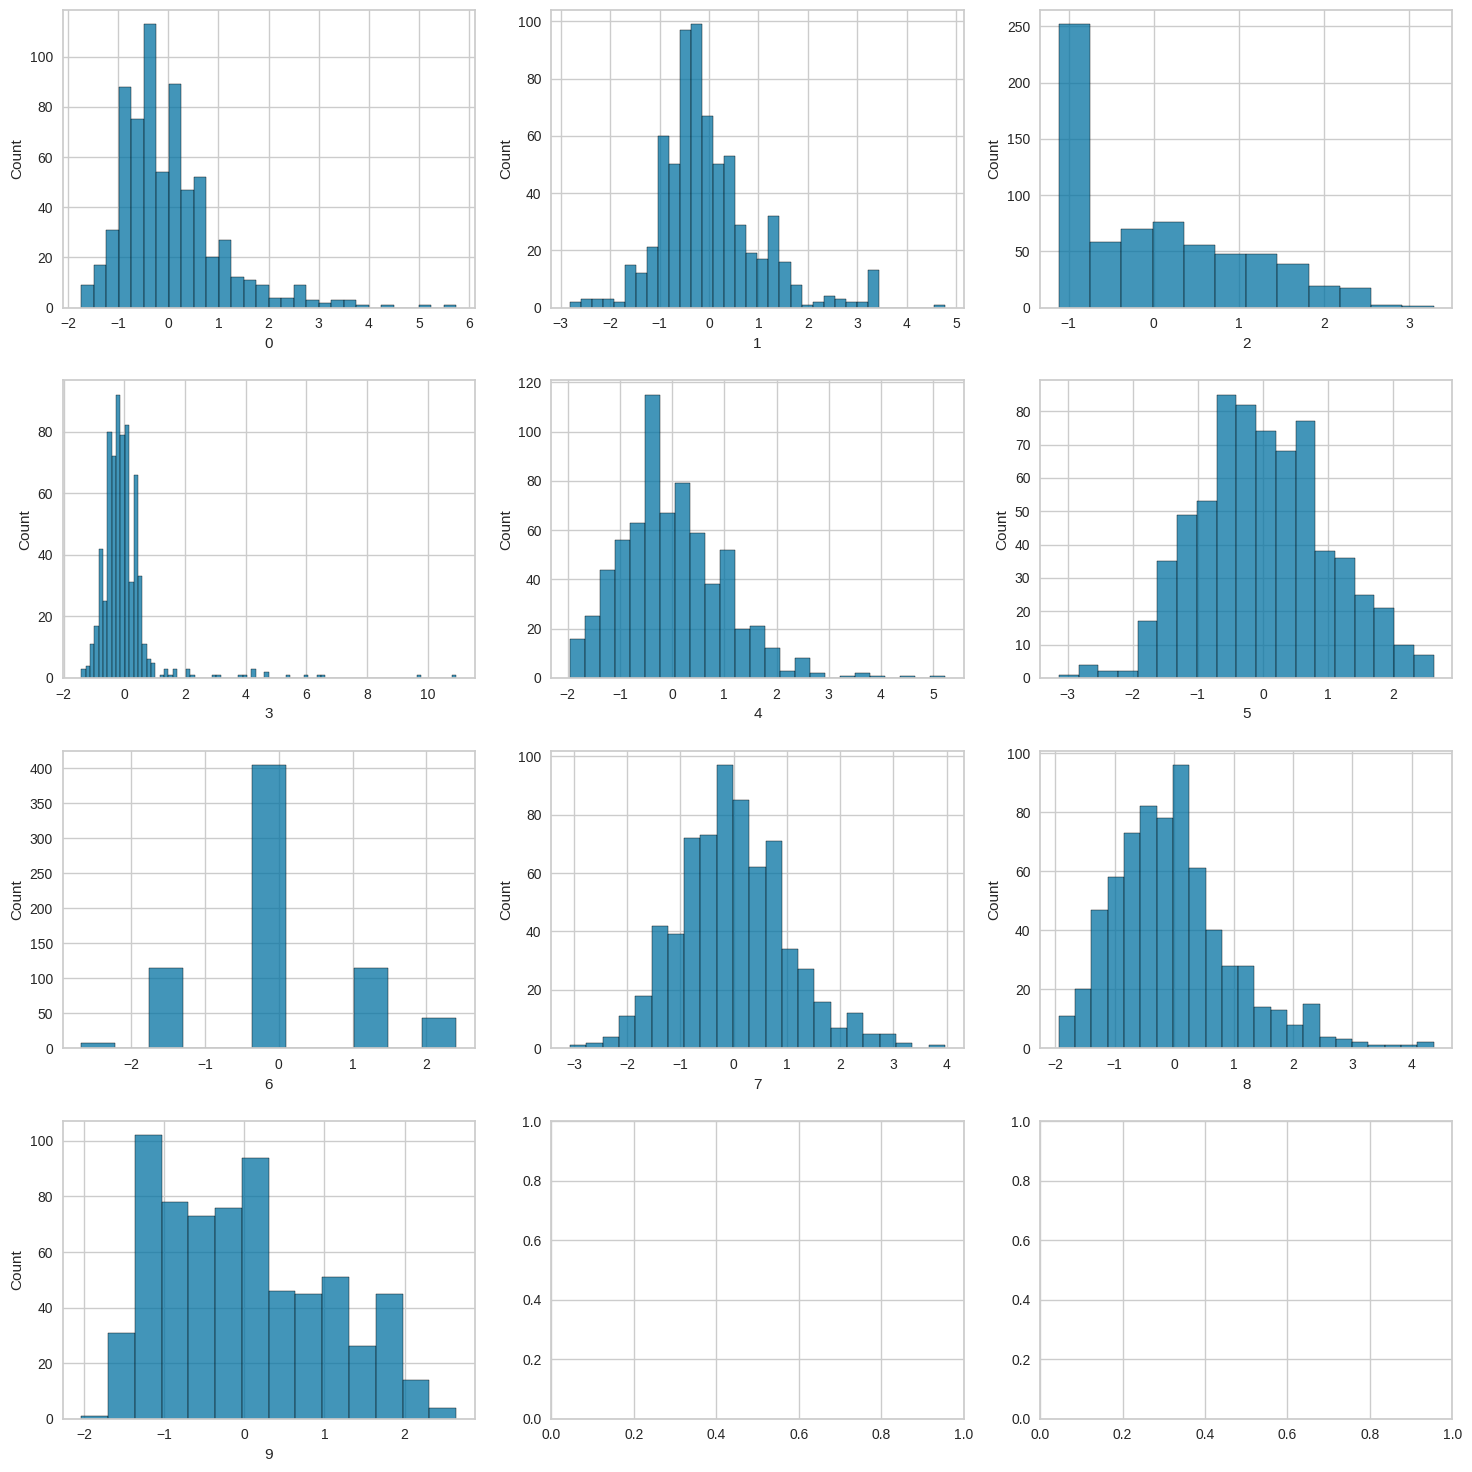

In [15]:
# Mostramos también el conjunto original

fig, axes = plt.subplots(4,3,figsize=(15,15))
X_train_frame = pd.DataFrame(X_train_o)
X_train_frame.columns=X_train_frame.columns
for i, c in enumerate(X_train_frame.columns):
    ax = axes.reshape(-1)[i]
    if X_train_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_frame,ax=ax)
plt.tight_layout()

## Apartado b:
Empezaremos por Naïve Bayes, ajusta un modelo para distribuciones gausianas a los dos conjuntos de datos y evalúa adecuadamente la calidad de los modelos.

In [16]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.best_score_1 = np.mean(cross_val_score(gnb,X_train_o,y_train,cv=10))
gnb.best_score_2 = np.mean(cross_val_score(gnb,X_train_g,y_train,cv=10))
print('Conjunto con variables originales: ', gnb.best_score_1)
print('Conjunto con variables transformadas: ', gnb.best_score_2)

Conjunto con variables originales:  0.7377877237851662
Conjunto con variables transformadas:  0.7216751918158568


El best_score en gaussianNB nos representa el rendimiento de este modelo con los datos proporcionados.

Observamos que realiza un trabajo decente con los dos conjuntos. Estos valores nos indican que acertarían en la clasificación de datos nuevos en sus respectivas clases un 74% y un 72%, sorprendentemente mostrando mejores resultados con el conjunto no transformado.

In [17]:
gnb_model = gnb.fit(X_train_o, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X.columns
means

gnb_model = gnb.fit(X_train_g, y_train)

print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X.columns
means

Priors: [0.20553936 0.25947522 0.2303207  0.30466472]
Means:



,art galleries,dance clubs,juice bars,restaurants,museums,resorts,parks/picnic spots,beaches,theaters,religious institutions
0,0.095,-0.355,0.322,-0.136,-0.219,-0.174,0.016,-0.007,-0.237,0.029
1,0.037,0.288,1.066,0.155,0.621,0.668,0.904,-0.250,-0.011,-0.707
2,-0.031,0.178,-0.576,0.295,0.219,0.396,-0.298,0.225,0.130,0.122
3,-0.072,-0.140,-0.689,-0.263,-0.546,-0.751,-0.556,0.048,0.071,0.490


Means:



,art galleries,dance clubs,juice bars,restaurants,museums,resorts,parks/picnic spots,beaches,theaters,religious institutions
0,0.085,-0.364,0.344,-0.142,-0.198,-0.174,0.016,-0.007,-0.258,0.048
1,0.096,0.266,0.928,0.397,0.609,0.668,0.904,-0.250,0.030,-0.723
2,-0.075,0.147,-0.466,0.226,0.228,0.396,-0.298,0.225,0.130,0.133
3,-0.082,-0.092,-0.670,-0.413,-0.557,-0.751,-0.556,0.048,0.050,0.483


Vemos que las probabilidades a priori están más o menos equilibradas, rondando el 20-30% para cada una. Analizemos ahora las medias de los conjuntos.

Por lo general, observamos medias similares entre las clases para los dos conjuntos, lo cual es natural teniendo un best_score tan similar.
Debido a esto, podemos centrarnos en encontrar identificadores comunes para los dos conjuntos. Se observa por lo general que las variables presentan diferencias 2 a 2, donde 2 de las 4 clases contienen valores positivos y las otras dos negativos.

In [18]:
print('Conjunto O:')
gnb_model_o = gnb.fit(X_train_o, y_train)
print(classification_report(y_test, gnb_model.predict(X_test_o)))
results_df = save_results(gnb_model, X_test_o, y_test, 'GNB_O', results_df)

print('Conjunto G:')
gnb_model_g = gnb.fit(X_train_g, y_train)
print(classification_report(y_test, gnb_model.predict(X_test_g)))
results_df = save_results(gnb_model, X_test_g, y_test, 'GNB_G', results_df)

Conjunto O:
              precision    recall  f1-score   support

           0       0.55      0.65      0.60        60
           1       0.77      0.77      0.77        77
           2       0.79      0.50      0.61        68
           3       0.70      0.81      0.75        89

    accuracy                           0.69       294
   macro avg       0.70      0.68      0.68       294
weighted avg       0.71      0.69      0.69       294

Conjunto G:
              precision    recall  f1-score   support

           0       0.63      0.68      0.66        60
           1       0.71      0.75      0.73        77
           2       0.77      0.63      0.69        68
           3       0.78      0.80      0.79        89

    accuracy                           0.72       294
   macro avg       0.72      0.72      0.72       294
weighted avg       0.73      0.72      0.72       294



Se observa que el conjunto transformado presenta mejor precisión (mejora en las predicciones positivas) y recall (capturó más verdaderos positivos). Por lo tanto, observamos que el conjunto transformado es más selectivo (menos falsos positivos) y captura más verdaderos positivos.

Como se mencionó anteriormente, la clase 0 tiene el menor número de elementos. Observamos que es la clase que tiene los peores resultados en cuanto a precisión, lo que nos indica que el modelo tiene un mayor problema en cuanto a clasificar correctamente los ejemplos en esa clase.

Conjunto O:                                                             Conjunto G:


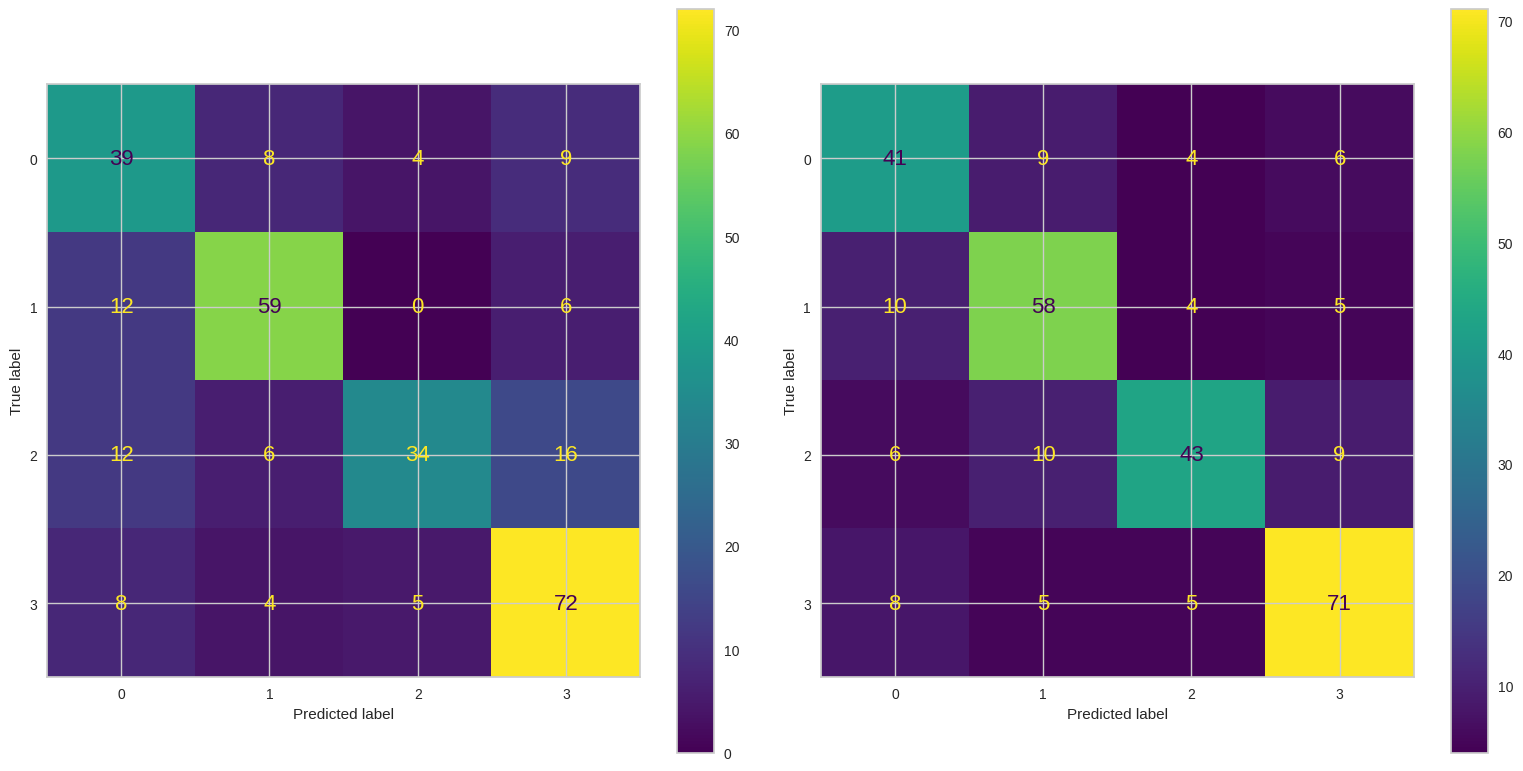

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
gnb_model_o = gnb.fit(X_train_o, y_train)
ConfusionMatrixDisplay.from_estimator(gnb_model_o, X_test_o, y_test, ax=axes[0]) 
gnb_model_g = gnb.fit(X_train_g, y_train)
ConfusionMatrixDisplay.from_estimator(gnb_model_g, X_test_g, y_test, ax=axes[1]) 

plt.tight_layout()
print('Conjunto O:                                                             Conjunto G:')
plt.show()

Conjunto O:


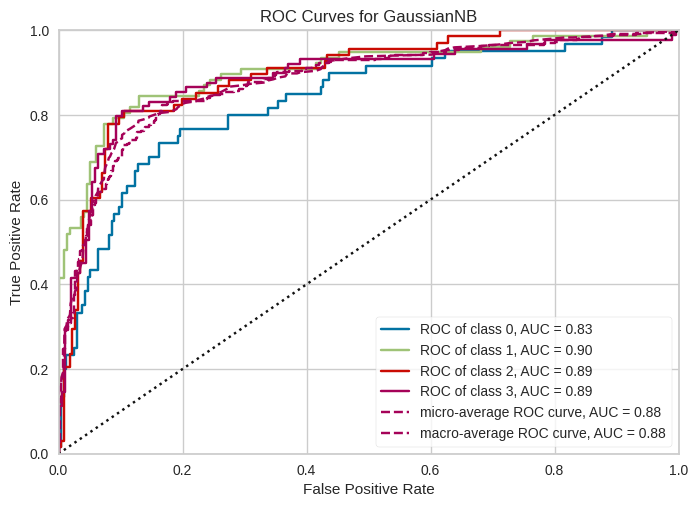

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GaussianNB())

Conjunto G:


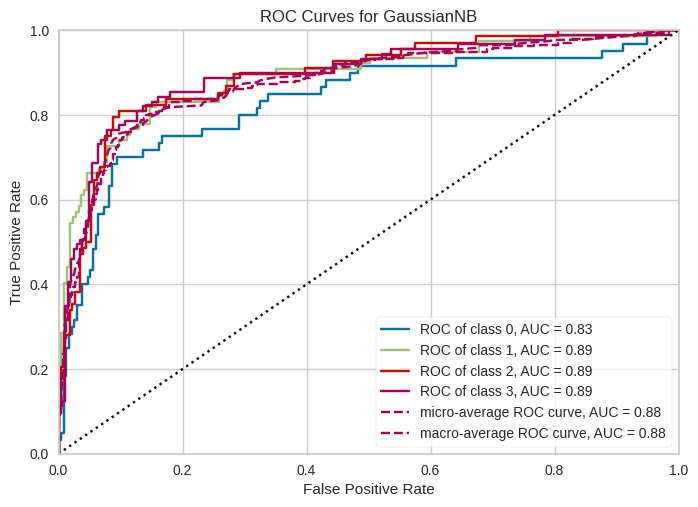

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GaussianNB())

In [20]:
from yellowbrick.classifier.rocauc import roc_auc

print('Conjunto O:')
gnb_model_o = gnb.fit(X_train_o, y_train)
roc_auc(gnb_model_o, X_train_o, y_train, X_test_o, y_test)

print('Conjunto G:')
gnb_model_g = gnb.fit(X_train_g, y_train)
roc_auc(gnb_model_g, X_train_g, y_train, X_test_g, y_test)

La curva ROC es similar en los dos conjuntos y presenta buenos resultados pero con margen de mejora en la clasificación correcta de elementos.

Vemos que los dos conjuntos clasifican correctamente, pero hay una notable mejora en como el conjunto transformado clasifica la clase 2.

En conclusión, podemos ver que Naive Bayes hace un trabajo decente con los datos proporcionados, que no excelente, con los dos conjuntos, pero en especial con el conjunto gaussiano. Es razonable debido a que GaussianNB puede realizar un mejor trabajo con datos más cercanos a gaussinidad.

## Apartado C
Al hacer la exploración de los datos probablemente viste que hay cierta correlación entre variables, por lo que es posible que los datos se desvíen de lo que asume Naïve Bayes. Ajusta un modelo discriminante lineal (LDA) a los dos conjuntos de datos y evalúa adecuadamente la calidad de los modelos.

In [21]:
lda = LinearDiscriminantAnalysis()
lda.best_score_1 = np.mean(cross_val_score(lda,X_train_o,y_train,cv=10))
lda.best_score_2 = np.mean(cross_val_score(lda,X_train_g,y_train,cv=10))
print(lda.best_score_1)
print(lda.best_score_2)

0.7595055413469736
0.7361679454390452


Vemos que el acierto del modelo para los dos grupos es casi igual al conseguido con Naive Bayes, de nuevo con mejor best_score para el conjunto original. Haremos ahora un entrenamiento y compararemos su rendimiento al anterior.

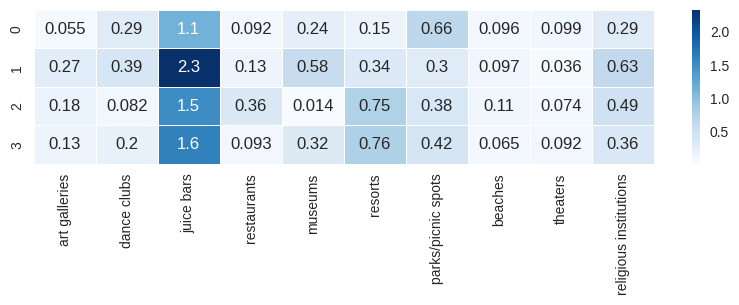

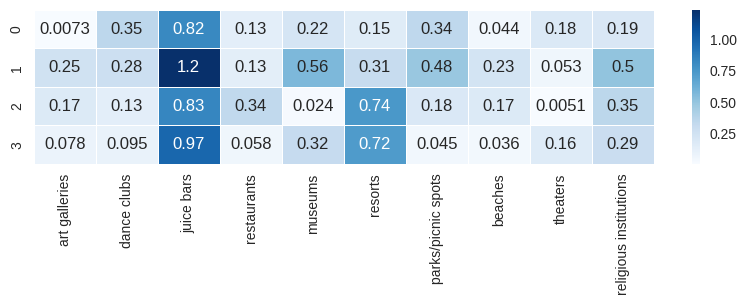

In [22]:
# No hay hiperparámetros por ajustar

lda_model_o = LinearDiscriminantAnalysis().fit(X_train_o, y_train)
lda_model_g = LinearDiscriminantAnalysis().fit(X_train_g, y_train)


coefs = pd.DataFrame(lda_model_o.coef_)
coefs.columns = X.columns
# coefs.T

plt.figure(figsize=(10,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

coefs = pd.DataFrame(lda_model_g.coef_)
coefs.columns = X.columns
# coefs.T
plt.figure(figsize=(10,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Los dos conjuntos presentan una alta importancia en el atributo de juice bars, así como, pero en menor medida, 'museums' 'resorts' y 'religious_institutions'. Un distintivo interesante se encuentra en 'parks/picnic spots', donde el conjunto gaussiano es capaz de identificar más fácilmente la clase 1 que las otras, a diferencia del conjunto original, que más facilmente identifica la clase 0.

In [23]:
print(classification_report(y_test, lda_model_o.predict(X_test_o)))
results_df = save_results(lda_model_o, X_test_o, y_test, 'LDA_O', results_df)

print(classification_report(y_test, lda_model_g.predict(X_test_g)))
results_df = save_results(lda_model_g, X_test_g, y_test, 'LDA_G', results_df)

              precision    recall  f1-score   support

           0       0.72      0.43      0.54        60
           1       0.71      0.84      0.77        77
           2       0.75      0.75      0.75        68
           3       0.79      0.87      0.82        89

    accuracy                           0.74       294
   macro avg       0.74      0.72      0.72       294
weighted avg       0.74      0.74      0.73       294

              precision    recall  f1-score   support

           0       0.57      0.47      0.51        60
           1       0.73      0.78      0.75        77
           2       0.74      0.75      0.74        68
           3       0.79      0.83      0.81        89

    accuracy                           0.72       294
   macro avg       0.71      0.71      0.71       294
weighted avg       0.72      0.72      0.72       294



Por lo general, el rendimiento de los dos conjuntos es similar, pero hay una diferencia notable en la precision del conjunto original para la clase 0, lo que nos indica que realiza menos falsos positivos para esa clase, y se comporta de forma similar (o igual) para las otras clases.

Conjunto O:                                                             Conjunto G:


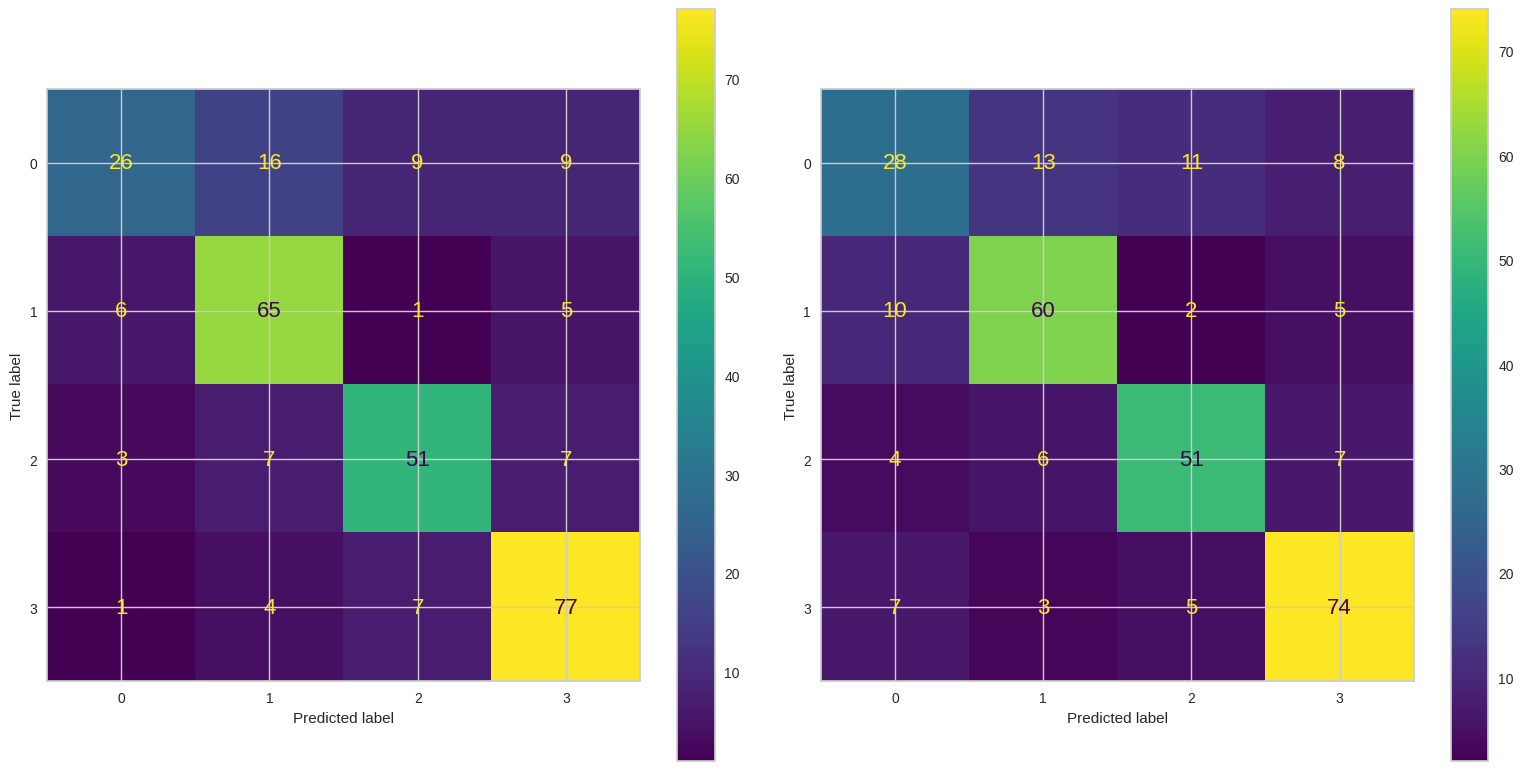

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

ConfusionMatrixDisplay.from_estimator(lda_model_o, X_test_o, y_test, ax=axes[0]) 


ConfusionMatrixDisplay.from_estimator(lda_model_g, X_test_g, y_test, ax=axes[1]) 

plt.tight_layout()
print('Conjunto O:                                                             Conjunto G:')
plt.show()

En efecto, el conjunto original realiza menos falsos positivos (10 vs 21) en la clase 0 y se comporta de manera muy similar en las otras clases, si bien con una pequeña diferencia positiva en la clase 1 y negativa en la clase 3.

Conjunto O:


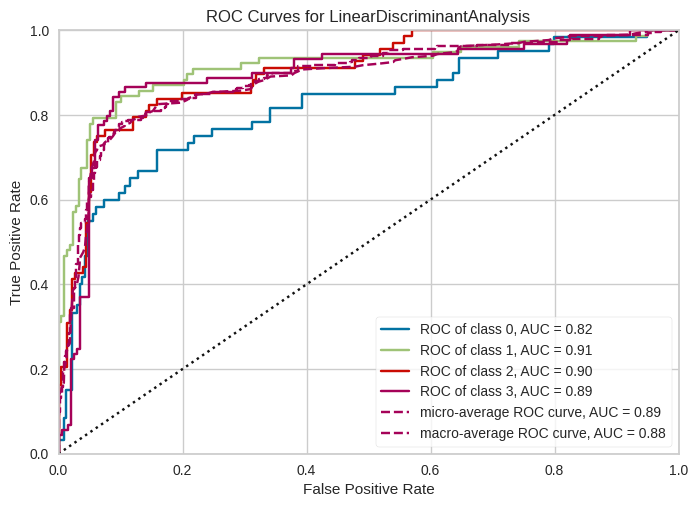

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for LinearDiscriminantAnalysis'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=LinearDiscriminantAnalysis())

Conjunto G:


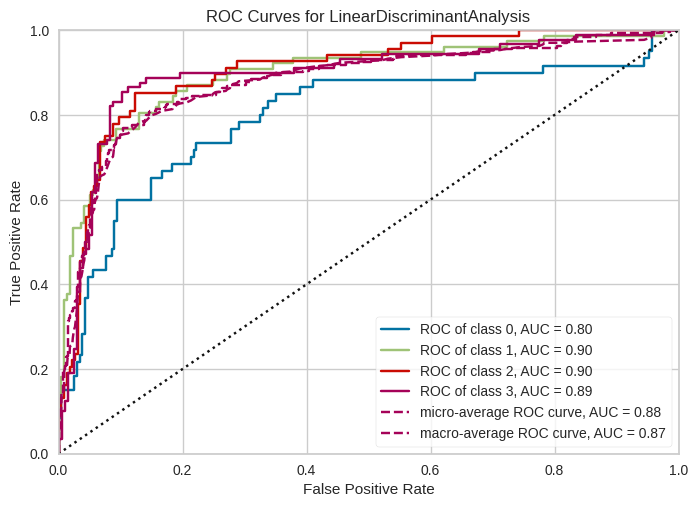

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for LinearDiscriminantAnalysis'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=LinearDiscriminantAnalysis())

In [25]:
print('Conjunto O:')
roc_auc(lda_model_o, X_train_o, y_train, X_test_o, y_test)

print('Conjunto G:')
roc_auc(lda_model_g, X_train_g, y_train, X_test_g, y_test)

La curva ROC, aunque buena en los dos conjuntos, presenta mejores resultados en el conjunto original.

En conclusión, vemos que un modelo gaussinizado con LDA no sería la mejor elección, ya que trabaja de peor forma al original.

## Apartado D:
Ajusta un modelo de regresión logística a los dos conjuntos de datos explorando los hiperparámetros de este modelo adecuadamente (el conjunto de datos es pequeño, así que el ajuste debería ser rápido). Evalúa la calidad de los modelos.

In [26]:
lr= LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs_o =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs_o.fit(X_train_o, y_train)
show_html(pd.DataFrame(lr_gs_o.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
21,"{'C': 1.0, 'penalty': 'l2'}",0.781,1
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.781,2
27,"{'C': 7.943282347242813, 'penalty': 'l2'}",0.781,3
25,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.781,3
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.780,5


Vemos que tenemos un conjunto de parámetros mejor así que nos quedaremos con ese.

In [27]:
lr_gs_g =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs_g.fit(X_train_g, y_train)
show_html(pd.DataFrame(lr_gs_g.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
41,"{'C': 1000.0, 'penalty': 'l2'}",0.762,1
39,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.762,1
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.762,1
31,"{'C': 31.622776601683793, 'penalty': 'l2'}",0.762,1
37,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.762,1


En este caso tenemos varios conjuntos válidos, nos podemos quedar con cualquiera de ellos.

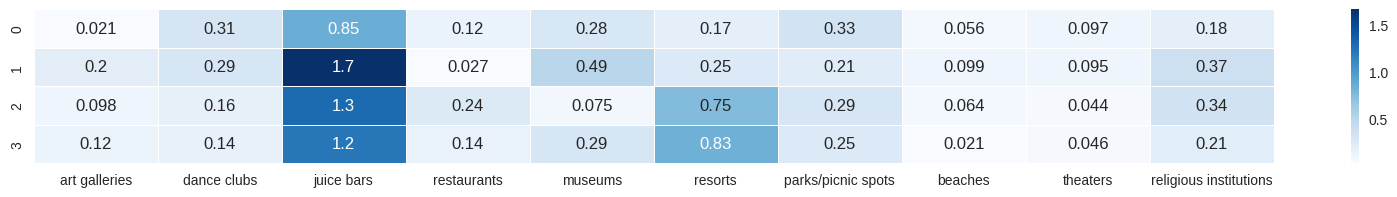

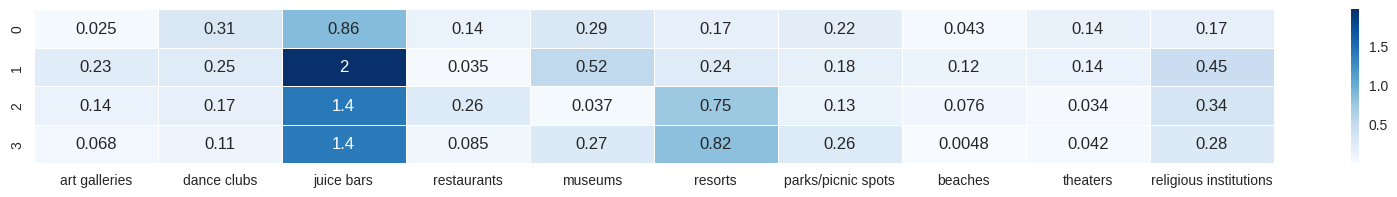

In [28]:
coefs = pd.DataFrame(lr_gs_o.best_estimator_.coef_)
coefs.columns = X.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

coefs = pd.DataFrame(lr_gs_g.best_estimator_.coef_)
coefs.columns = X.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

A diferencia de LDA, en la regresión logística observamos que, además de presentar importancias a las mismas variables (con el conjunto gaussinizado enfatizándolas más que el original) ha desaparecido la disparidad entre las clases 0/1 para 'parks/picnic spots' que encontrábamos en LDA.

In [29]:
print(classification_report(y_test, lr_gs_o.predict(X_test_o)))
results_df = save_results(lr_gs_o, X_test_o, y_test, 'Lg_o_non_bal', results_df)

              precision    recall  f1-score   support

           0       0.74      0.42      0.53        60
           1       0.68      0.84      0.76        77
           2       0.77      0.74      0.75        68
           3       0.77      0.87      0.81        89

    accuracy                           0.74       294
   macro avg       0.74      0.72      0.71       294
weighted avg       0.74      0.74      0.73       294



In [30]:
print(classification_report(y_test, lr_gs_g.predict(X_test_g)))
results_df = save_results(lr_gs_g, X_test_g, y_test, 'Lg_g_non_bal', results_df)

              precision    recall  f1-score   support

           0       0.66      0.45      0.53        60
           1       0.69      0.83      0.75        77
           2       0.78      0.74      0.76        68
           3       0.79      0.85      0.82        89

    accuracy                           0.74       294
   macro avg       0.73      0.72      0.72       294
weighted avg       0.73      0.74      0.73       294



Los dos conjuntos realizan un trabajo bastante similar en lo que respecta a la detección de verdaderos positivos, pero el conjunto gaussinizado pierde un poco de fuelle en la precisión de la clase 0, lo que nos indica que tiene más dificultades identificando que un elemento es de esa clase.

Conjunto O:                                                             Conjunto G:


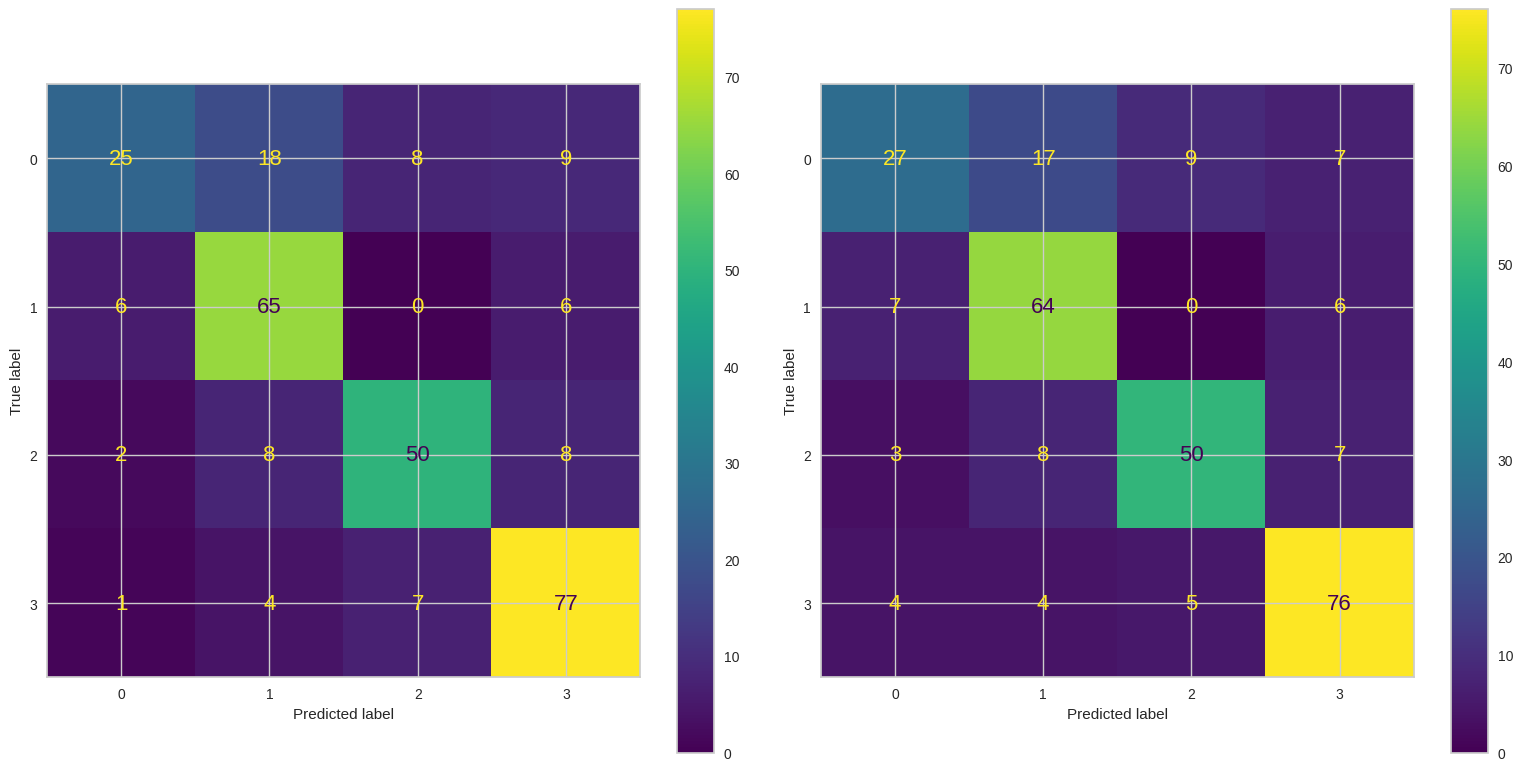

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

gnb_model = gnb.fit(X_train_o, y_train)
ConfusionMatrixDisplay.from_estimator(lr_gs_o, X_test_o, y_test, ax=axes[0]) 

gnb_model = gnb.fit(X_train_g, y_train)
ConfusionMatrixDisplay.from_estimator(lr_gs_g, X_test_g, y_test, ax=axes[1]) 

plt.tight_layout()
print('Conjunto O:                                                             Conjunto G:')
plt.show()

Esto se observa más fácilmente con la matriz de confusión, que nos muestra que las clases 1/2/3 tienen resultados muy similares, con una diferencia de un positivo no detectado en las clases 1/3 en el conjunto G, pero con dificultades mayores en la clase 0 (9 vs 14 falsos positivos).

Conjunto O:


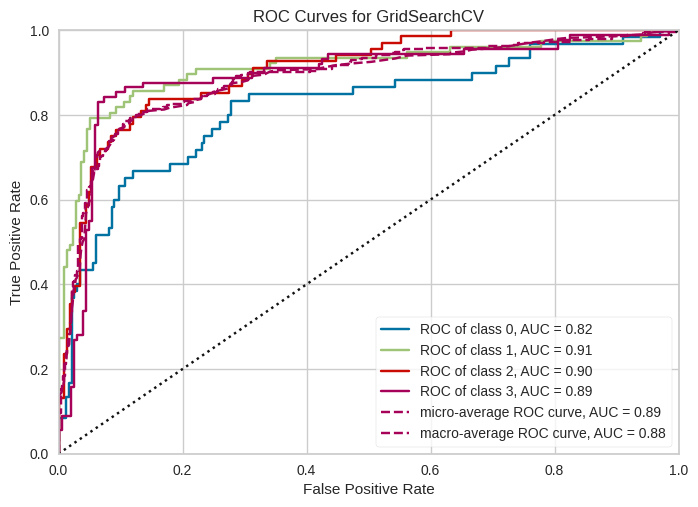

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GridSearchCV(cv=10,
                              estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                                          'penalty': ['l1', 'l2']}))

Conjunto G:


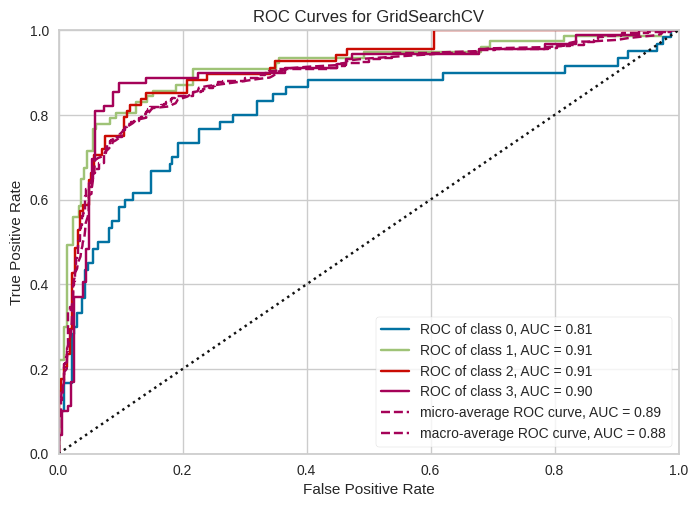

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GridSearchCV(cv=10,
                              estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                                          'penalty': ['l1', 'l2']}))

In [32]:
print('Conjunto O:')
roc_auc(lr_gs_o, X_train_o, y_train, X_test_o, y_test)

print('Conjunto G:')
roc_auc(lr_gs_g, X_train_g, y_train, X_test_g, y_test)

Los resultados vuelven a ser muy similares y buenos, exceptuando la clase 0, que realiza un peor trabajo.

Dado que las clases que tiene el conjunto de datos no están completamente balanceadas podríamos usar el parámetro class_weight de este modelo para que se tenga en cuenta esta circunstancia usando del valor balanced. Haz un nuevo ajuste de la regresión logística con los dos conjuntos de datos utilizando este hiperparámetro. ¿Qué modelo elegirías de entre todos los que has obtenido? ¿Por qué?

Volvemos a hacer el mismo procedimiento, pero añadiendo el parametro "class_weight='balanced'".

No es necesario comentar el ajuste de hiperparámetros ya que se realiza igual que anteriormente. Mencionaré las diferencias relevantes al añadir el parámetro.

In [33]:
lr_bal= LogisticRegression(max_iter=10000, class_weight='balanced')
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs_o_bal =  GridSearchCV(lr_bal,param,cv=10, n_jobs=-1, refit=True)
lr_gs_o_bal.fit(X_train_o, y_train)
show_html(pd.DataFrame(lr_gs_o.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
21,"{'C': 1.0, 'penalty': 'l2'}",0.781,1
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.781,2
27,"{'C': 7.943282347242813, 'penalty': 'l2'}",0.781,3
25,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.781,3
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.780,5


In [34]:
lr_gs_g_bal =  GridSearchCV(lr_bal,param,cv=10, n_jobs=-1, refit=True)
lr_gs_g_bal.fit(X_train_g, y_train)
show_html(pd.DataFrame(lr_gs_g.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
41,"{'C': 1000.0, 'penalty': 'l2'}",0.762,1
39,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.762,1
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.762,1
31,"{'C': 31.622776601683793, 'penalty': 'l2'}",0.762,1
37,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.762,1


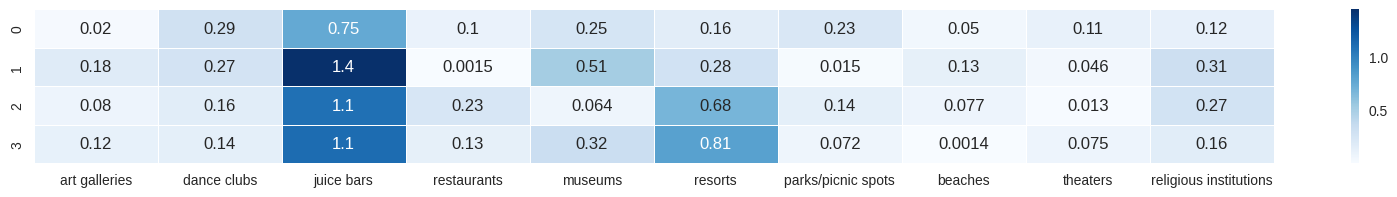

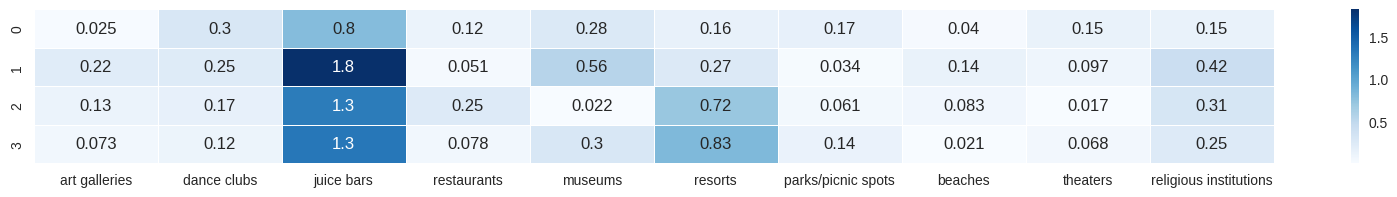

In [35]:
coefs = pd.DataFrame(lr_gs_o_bal.best_estimator_.coef_)
coefs.columns = X.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

coefs = pd.DataFrame(lr_gs_g_bal.best_estimator_.coef_)
coefs.columns = X.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Por lo general, la importancia en las variables se ha reducido para 'juice bars', la cuál recibía los valores más altos. No sería extraño especular que esta podía ser una variable muy importante para las clases con más elementos. Al equilibrar los pesos se reduce su importancia.

In [36]:
print(classification_report(y_test, lr_gs_o_bal.predict(X_test_o)))
results_df = save_results(lr_gs_o_bal, X_test_o, y_test, 'Lg_o_bal', results_df)

              precision    recall  f1-score   support

           0       0.72      0.60      0.65        60
           1       0.75      0.83      0.79        77
           2       0.73      0.78      0.75        68
           3       0.85      0.82      0.83        89

    accuracy                           0.77       294
   macro avg       0.76      0.76      0.76       294
weighted avg       0.77      0.77      0.77       294



In [37]:
print(classification_report(y_test, lr_gs_g_bal.predict(X_test_g)))
results_df = save_results(lr_gs_g_bal, X_test_o, y_test, 'Lg_g_bal', results_df)

              precision    recall  f1-score   support

           0       0.59      0.58      0.59        60
           1       0.75      0.81      0.78        77
           2       0.74      0.75      0.74        68
           3       0.84      0.79      0.81        89

    accuracy                           0.74       294
   macro avg       0.73      0.73      0.73       294
weighted avg       0.74      0.74      0.74       294



La mejora en los resultados no es notable en el conjunto G, pero si lo es en O, donde en especial la clase 0 (la que menos elementos tiene) consigue sustanciales mejores en recall (capacidad de capturar elementos de esa clase).

Conjunto O:                                                             Conjunto G:


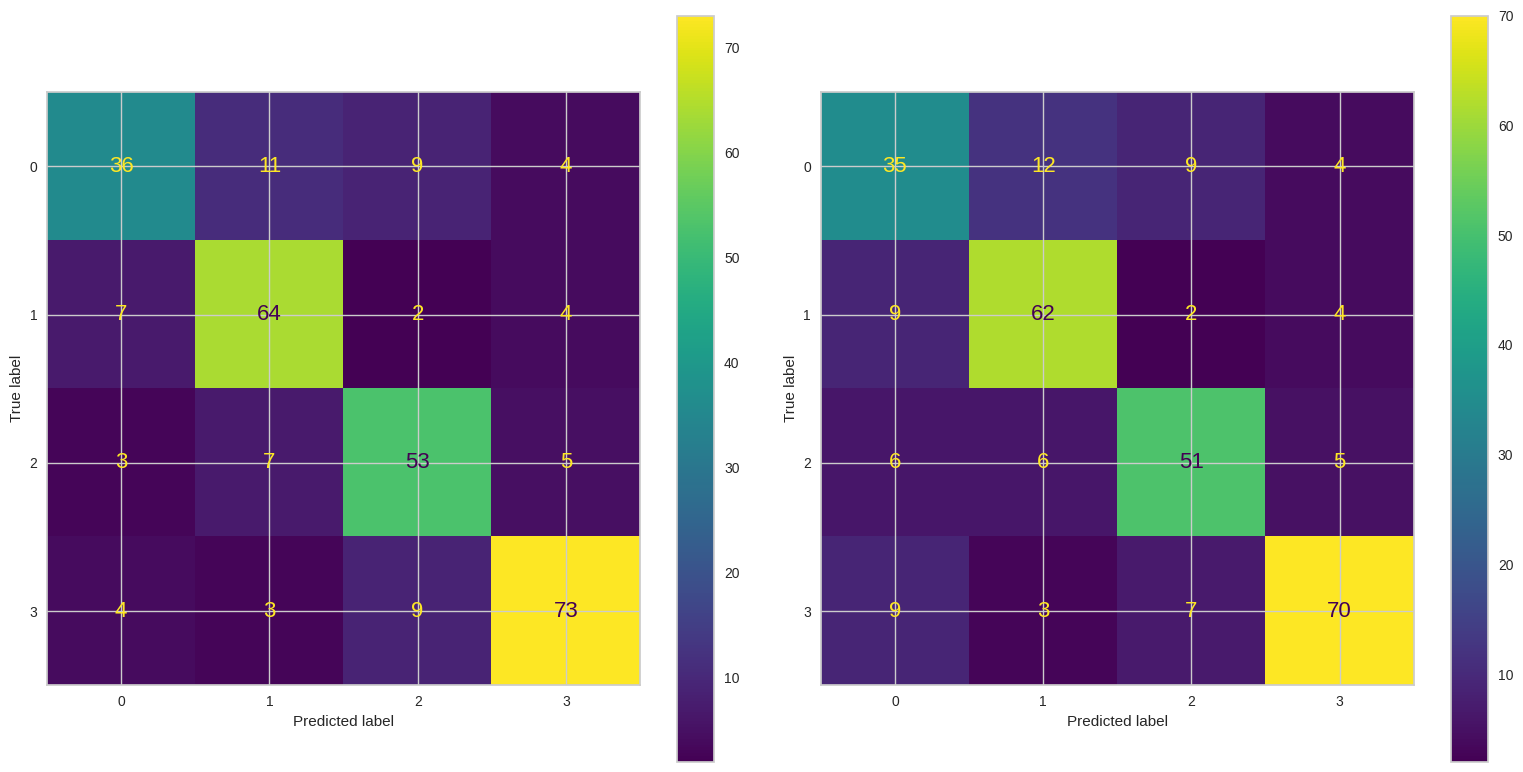

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

gnb_model = gnb.fit(X_train_o, y_train)
ConfusionMatrixDisplay.from_estimator(lr_gs_o_bal, X_test_o, y_test, ax=axes[0]) 

gnb_model = gnb.fit(X_train_g, y_train)
ConfusionMatrixDisplay.from_estimator(lr_gs_g_bal, X_test_g, y_test, ax=axes[1]) 

plt.tight_layout()
print('Conjunto O:                                                             Conjunto G:')
plt.show()

Si bien ahora captura ligeramente menos ejemplos de las clases con más elementos (1 y 3) la mejora en las clases restantes es muy notable.
De los dos modelos, el original realiza un mejor trabajo para todas las clases.

Conjunto O:


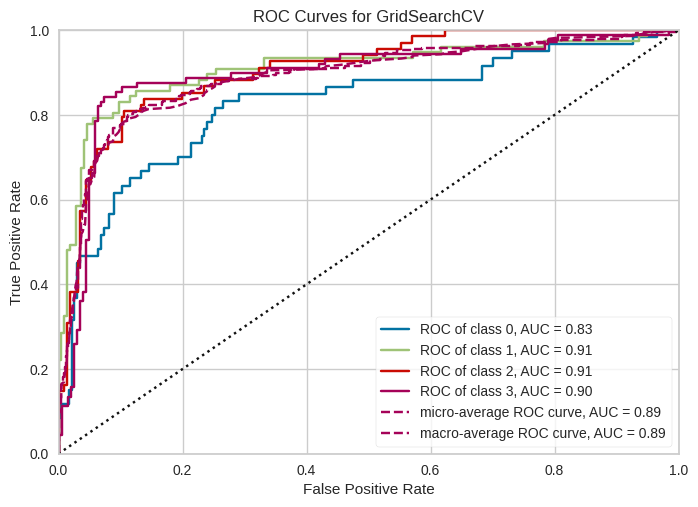

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GridSearchCV(cv=10,
                              estimator=LogisticRegression(class_weight='balanced',
                                                           max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                                          'penalty': ['l1', 'l2']}))

Conjunto G:


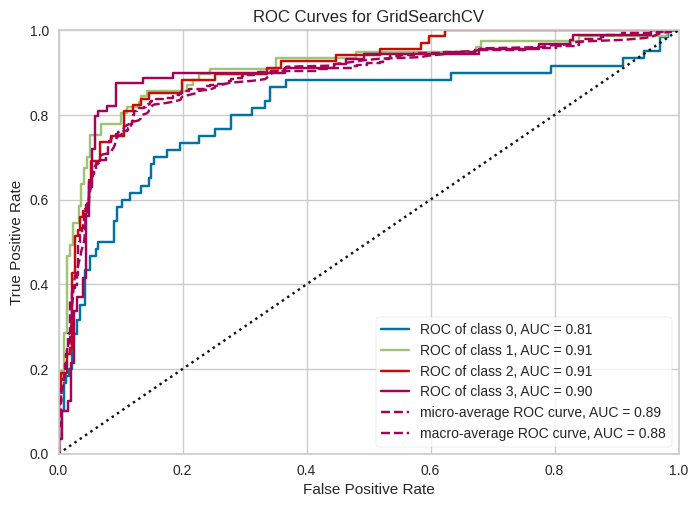

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GridSearchCV(cv=10,
                              estimator=LogisticRegression(class_weight='balanced',
                                                           max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                                          'penalty': ['l1', 'l2']}))

In [39]:
print('Conjunto O:')
roc_auc(lr_gs_o_bal, X_train_o, y_train, X_test_o, y_test)

print('Conjunto G:')
roc_auc(lr_gs_g_bal, X_train_g, y_train, X_test_g, y_test)

Vemos una ligera mejora en la clase 0, capturando menos falsos positivos y mejorando así su AUC. Si bien es una mejora baja, ya hemos visto que la mayoría de estos modelos trabajan dentro de un margen del 70/75%, así que las pequeñas mejoras son bienvenidas.

Por ultimo, ahora imprimiremos los resultados de todos los modelos y escogeremos el que mejor resultado ha obtenido en la clasificación con nuestros datos de test.

In [40]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Lg_o_bal,0.802,0.769,0.762,0.758,0.758
Lg_g_bal,0.777,0.759,0.758,0.742,0.740
LDA_O,NaN,0.745,0.741,0.723,0.721
Lg_o_non_bal,0.781,0.738,0.740,0.715,0.714
Lg_g_non_bal,0.762,0.738,0.730,0.718,0.717
GNB_G,NaN,0.724,0.722,0.717,0.717
LDA_G,NaN,0.724,0.707,0.707,0.705
GNB_O,NaN,0.694,0.701,0.681,0.681


Vemos que el modelo que aporta una mejor capacidad de clasificación lo encontramos en regresión logística balanceada, con el conjunto de datos original. Aplicar gausinidad no ha dado mejores resultados exceptuando Naive Bayes Gaussiano, ya que es el único que se aprovecha de este ajuste.

Debido a que el objetivo de nuestro problema era buscar la mejor manera posible de predecir el perfil de un usuario, este modelo nos permitirá hacerlo correctamente para, aproximadamente, 3/4 usuarios.

'juice bars', 'museums' y 'resorts' son los atributos más importantes para identificar las clases del conjunto de datos. En especial, 'juice bars' es muy efectivo para las clases con más elementos. En menor medida, 'religious institutions' y 'dance clubs' también dan información relevante al modelo.